### Using SARIMAX with other variables to predict crash rates

What other variables can we use with SARIMAX to predict crash rates? Speed limit? Road condition? Etc

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

In [3]:
df = pd.read_csv("C:/Users/chris/Documents/Senior_Project/CT_SeniorProject/CrashData_Repo1/data/interim/filtered_dataset.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768734 entries, 0 to 768733
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                768734 non-null  object 
 1   CRASH_DATE_EST_I               55503 non-null   object 
 2   CRASH_DATE                     768734 non-null  object 
 3   POSTED_SPEED_LIMIT             768734 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         768734 non-null  object 
 5   DEVICE_CONDITION               768734 non-null  object 
 6   WEATHER_CONDITION              768734 non-null  object 
 7   LIGHTING_CONDITION             768734 non-null  object 
 8   FIRST_CRASH_TYPE               768734 non-null  object 
 9   TRAFFICWAY_TYPE                768734 non-null  object 
 10  LANE_CNT                       91692 non-null   float64
 11  ALIGNMENT                      768734 non-null  object 
 12  ROADWAY_SURFACE_COND          

In [ ]:
# explore speed limit data

# Group by CRASH_DATE and calculate average speed limit
avg_speed_per_day = df.groupby("CRASH_DATE")["POSTED_SPEED_LIMIT"].mean().reset_index()
avg_speed_per_day.rename(columns={"POSTED_SPEED_LIMIT": "Average_Posted_Speed_Limit"}, inplace=True)
avg_speed_per_day["CRASH_DATE"] = pd.to_datetime(avg_speed_per_day["CRASH_DATE"])
avg_speed_per_day.set_index("CRASH_DATE", inplace=True)
avg_speed_per_day = avg_speed_per_day.asfreq("D")

avg_speed_per_day.head(20)

,Average_Posted_Speed_Limit
CRASH_DATE,
2018-01-01,28.578635
2018-01-02,28.103982
2018-01-03,29.190601
2018-01-04,28.472222
2018-01-05,28.378016
2018-01-06,28.500000
2018-01-07,27.414286
2018-01-08,27.724014
2018-01-09,28.297101


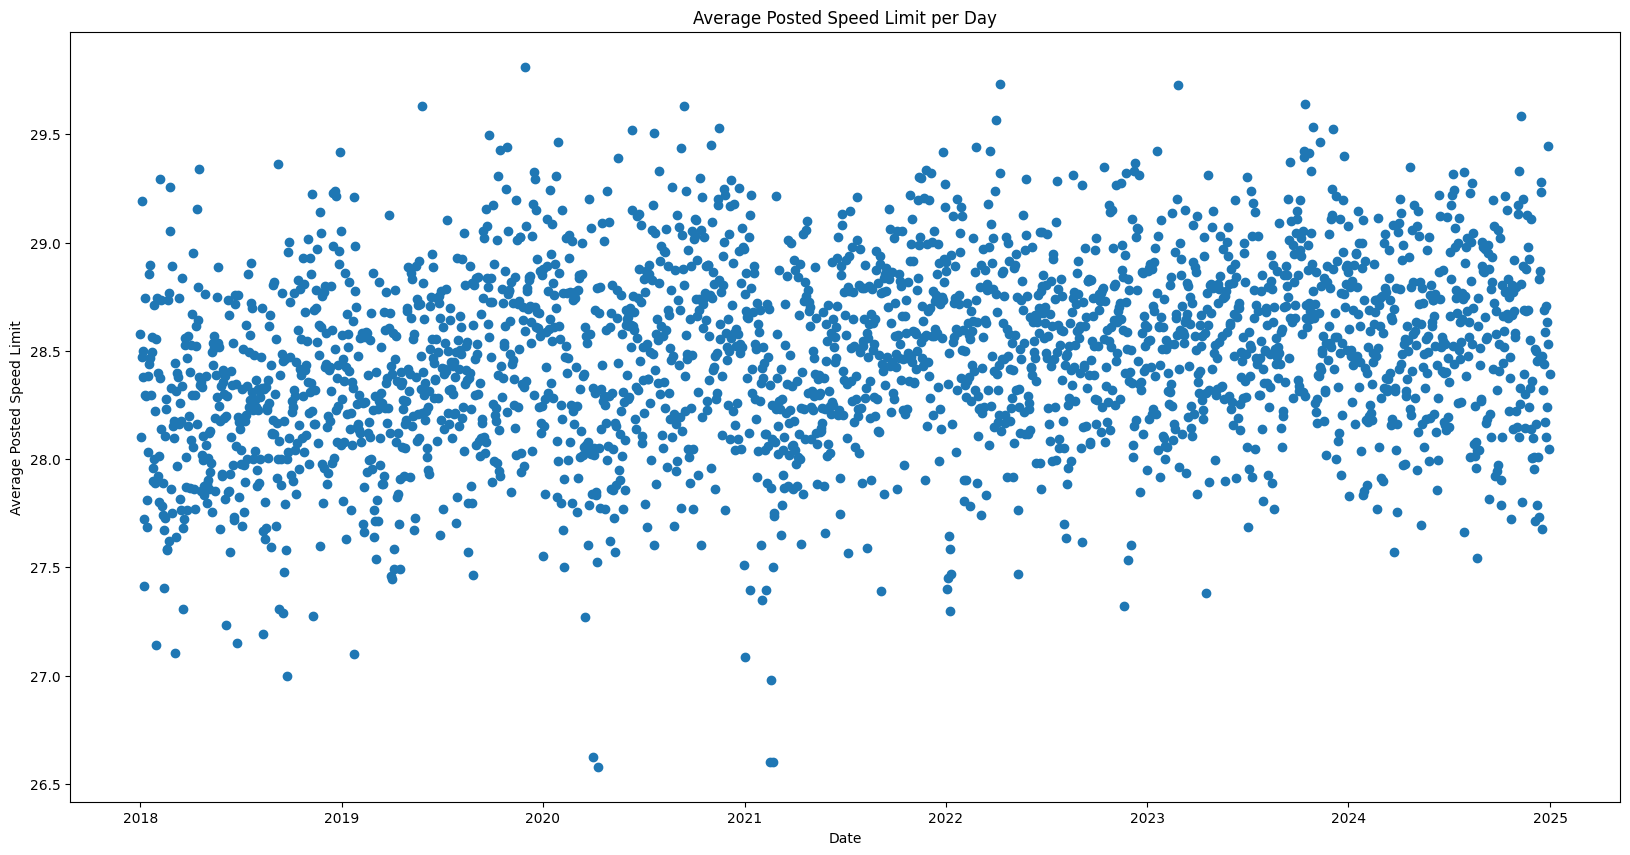

In [18]:
# plot scatter plot of average speed limit per day
plt.figure(figsize=(20, 10))
plt.scatter(avg_speed_per_day.index, avg_speed_per_day["Average_Posted_Speed_Limit"])
plt.title("Average Posted Speed Limit per Day")
plt.xlabel("Date")
plt.ylabel("Average Posted Speed Limit")
plt.show()


This doesn't seem worth it to explore using SARIMAX. There isn't enough variation in the daily average speed limit values. 

------------------------------
### DATA CLEANING

In [4]:
# filter df by date range 2022-2024 and only include LIGHTING_CONDITION, TRAFFIC_CONTROL_DEVICE, ROAD_DEFECT, and CRASH_DATE columns
df = df[(df["CRASH_DATE"] >= "2022-01-01") & (df["CRASH_DATE"] <= "2024-12-31")]
df = df[["CRASH_DATE", "LIGHTING_CONDITION", "TRAFFIC_CONTROL_DEVICE", "ROAD_DEFECT"]]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 331163 entries, 437571 to 768733
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   CRASH_DATE              331163 non-null  object
 1   LIGHTING_CONDITION      331163 non-null  object
 2   TRAFFIC_CONTROL_DEVICE  331163 non-null  object
 3   ROAD_DEFECT             331163 non-null  object
dtypes: object(4)
memory usage: 12.6+ MB


In [5]:
print(df.head(50))

        CRASH_DATE      LIGHTING_CONDITION    TRAFFIC_CONTROL_DEVICE  \
437571  2022-01-01                 UNKNOWN               NO CONTROLS   
437572  2022-01-01                DARKNESS               NO CONTROLS   
437573  2022-01-01  DARKNESS, LIGHTED ROAD               NO CONTROLS   
437574  2022-01-01                DARKNESS            TRAFFIC SIGNAL   
437575  2022-01-01  DARKNESS, LIGHTED ROAD            TRAFFIC SIGNAL   
437576  2022-01-01  DARKNESS, LIGHTED ROAD               NO CONTROLS   
437577  2022-01-01  DARKNESS, LIGHTED ROAD            TRAFFIC SIGNAL   
437578  2022-01-01  DARKNESS, LIGHTED ROAD            TRAFFIC SIGNAL   
437579  2022-01-01  DARKNESS, LIGHTED ROAD               NO CONTROLS   
437580  2022-01-01  DARKNESS, LIGHTED ROAD            TRAFFIC SIGNAL   
437581  2022-01-01  DARKNESS, LIGHTED ROAD               NO CONTROLS   
437582  2022-01-01  DARKNESS, LIGHTED ROAD            TRAFFIC SIGNAL   
437583  2022-01-01  DARKNESS, LIGHTED ROAD               NO CONT

In [23]:
print(df.isnull().sum())

CRASH_DATE                0
LIGHTING_CONDITION        0
TRAFFIC_CONTROL_DEVICE    0
ROAD_DEFECT               0
dtype: int64


In [25]:
# Ensure CRASH_DATE is in datetime format
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])

df_crashes_per_day = df.groupby("CRASH_DATE").size().reset_index(name="Total_Crashes")

# Flag 1: Poor lighting
poor_lighting_values = ['DUSK', 'DAWN', 'DARKNESS, LIGHTED ROAD', 'DARKNESS']
df['Poor_Lighting_Flag'] = df['LIGHTING_CONDITION'].isin(poor_lighting_values).astype(int)

# Flag 2: No control device
df['No_Control_Flag'] = (df['TRAFFIC_CONTROL_DEVICE'] == 'NO CONTROLS').astype(int)

# Flag 3: Road defect present (anything except "NO DEFECTS")
df['Road_Defect_Flag'] = (df['ROAD_DEFECT'] != 'NO DEFECTS').astype(int)

# Group by CRASH_DATE to get daily proportions
daily_flags = df.groupby('CRASH_DATE')[[
    'Poor_Lighting_Flag',
    'No_Control_Flag',
    'Road_Defect_Flag'
]].mean().reset_index()

# Optional: Merge with your daily crash totals (df_crashes_per_day)
df_features = df_crashes_per_day.merge(daily_flags, on="CRASH_DATE", how="left")

# Preview the result
df_features.head()

,CRASH_DATE,Total_Crashes,Poor_Lighting_Flag,No_Control_Flag,Road_Defect_Flag
0,2022-01-01,252,0.702381,0.543651,0.250000
1,2022-01-02,193,0.383420,0.523316,0.300518
2,2022-01-03,289,0.325260,0.525952,0.207612
3,2022-01-04,239,0.355649,0.506276,0.200837
4,2022-01-05,210,0.371429,0.590476,0.228571


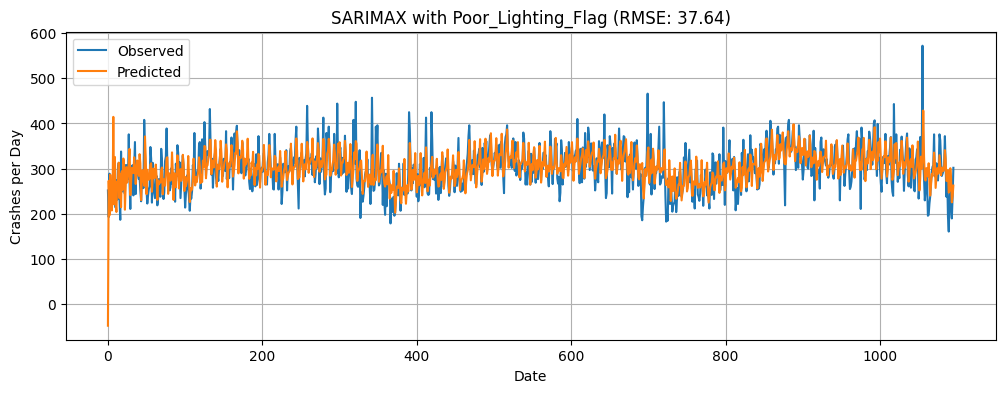

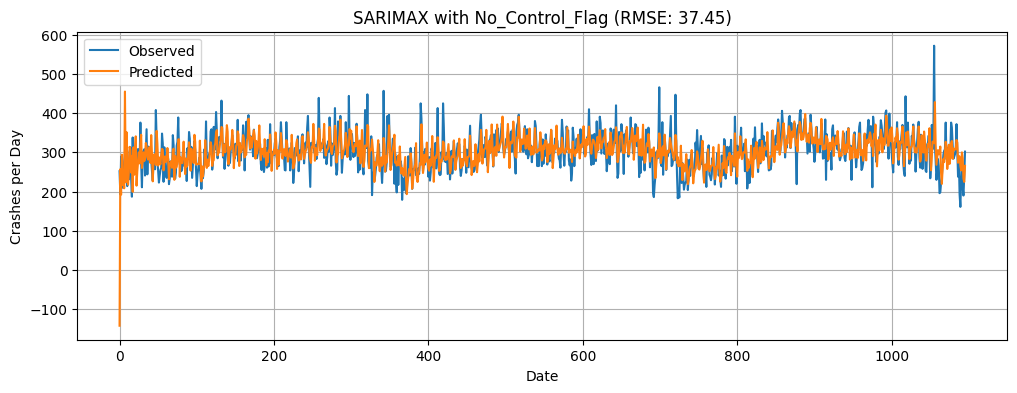

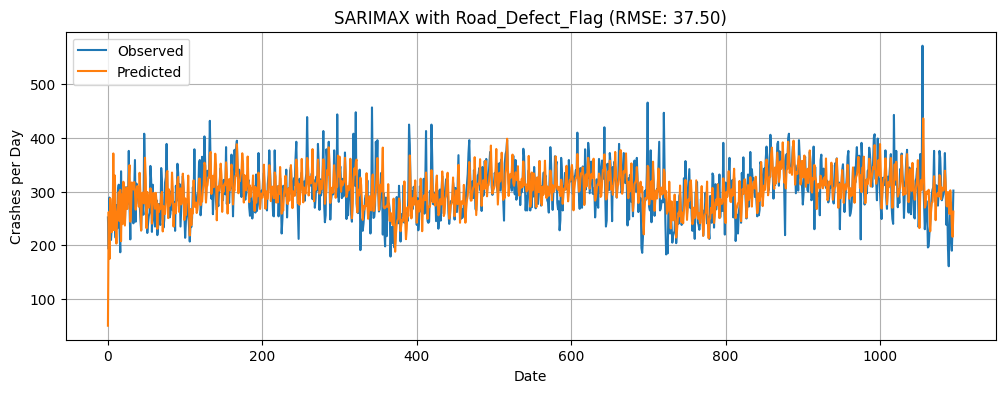

Poor_Lighting_Flag: RMSE = 37.64
No_Control_Flag: RMSE = 37.45
Road_Defect_Flag: RMSE = 37.50


In [26]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Define target and list of explanatory variables
endog = df_features["Total_Crashes"]
exog_variables = ["Poor_Lighting_Flag", "No_Control_Flag", "Road_Defect_Flag"]
sarimax_results = []

for var in exog_variables:
    exog = df_features[[var]]
    model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    results = model.fit(disp=False)

    predictions = results.fittedvalues
    rmse = np.sqrt(mean_squared_error(endog[1:], predictions[1:]))  # skip first diff value
    sarimax_results.append((var, rmse))

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(endog, label="Observed")
    plt.plot(predictions, label="Predicted")
    plt.title(f"SARIMAX with {var} (RMSE: {rmse:.2f})")
    plt.xlabel("Date")
    plt.ylabel("Crashes per Day")
    plt.legend()
    plt.grid(True)
    plt.show()

# Print summary
for var, rmse in sarimax_results:
    print(f"{var}: RMSE = {rmse:.2f}")
